# Car Pole using Deep Q-Learning

In [1]:
import numpy as np
import h5py
import string
import random
import tensorflow as tf


c:\users\hp\anaconda2\envs\translator\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Car Pole

In [25]:
import random
import gym
import math
import numpy as np
import tensorflow as tf
from collections import deque


class DQNCartPoleSolver():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 4])
        h = tf.layers.dense(self.state_, units=24, activation=tf.nn.tanh)
        h = tf.layers.dense(h, units=48, activation=tf.nn.tanh)
        self.Q = tf.layers.dense(h, units=2)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 2])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.01, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
            
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.sess.run(self.Q, feed_dict={self.state_: next_state})[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)
        rs = []

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            r_sum=0
            while not done:
                if e % 100 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                r_sum+= reward*self.gamma**i
            rs.append(r_sum)
            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100, rs
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))
            
            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e, rs

if __name__ == '__main__':
    agent = DQNCartPoleSolver()
    list_plot=agent.run()

[Episode 0] - Mean survival time over last 100 episodes was 12.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 15.04 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 23.46 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 79.4 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 133.69 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 137.17 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 134.09 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 155.4 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 151.83 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 149.35 ticks.
Did not solve after 999 episodes 😞


### 4.3

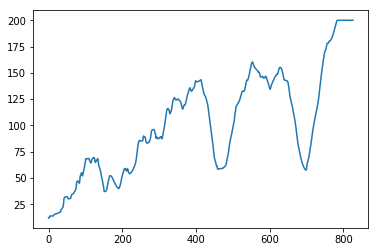

In [31]:
agent = DQNCartPoleSolver()
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

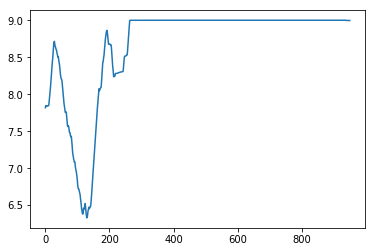

In [34]:
agent = DQNCartPoleSolver(gamma=0.9)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

[Episode 0] - Mean survival time over last 100 episodes was 15.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 31.26 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 34.06 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 121.78 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 136.02 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 138.34 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 152.08 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 142.03 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 152.69 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 193.98 ticks.
Ran 902 episodes. Solved after 802 trials ✔


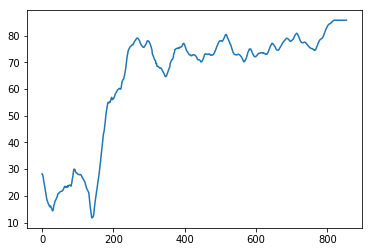

In [35]:
agent = DQNCartPoleSolver(gamma=0.99)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

[Episode 0] - Mean survival time over last 100 episodes was 38.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 16.39 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 29.3 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 117.65 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 132.85 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 149.33 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 155.18 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 146.23 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 155.76 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 141.04 ticks.
Did not solve after 999 episodes 😞


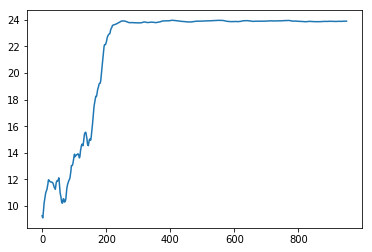

In [36]:
agent = DQNCartPoleSolver(gamma=0.96)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

 After running DQN for values of gamma equals to 1.0, 0.99, 0.96, 0.9 it is possible to notice that decreasing gamma can increase the stability of the model. However, when decreasing gamma the agent tends to not learn the model, as it happened for values of gamma equal to 0.9 and 0.96. Instead, for gamma= 0.99 the agent learn how to play the game and the system shows more stability than gamma=1.

### Try different values of epsilon

[Episode 0] - Mean survival time over last 100 episodes was 28.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 36.79 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 50.99 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 86.92 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 130.24 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 126.74 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 135.71 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 193.79 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 153.73 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 148.35 ticks.
Did not solve after 999 episodes 😞


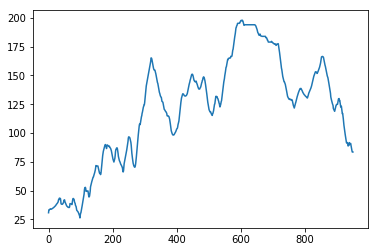

In [41]:
agent = DQNCartPoleSolver(epsilon=0.9)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

[Episode 0] - Mean survival time over last 100 episodes was 18.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 23.8 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 80.32 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 103.18 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 111.75 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 119.39 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 141.14 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 116.05 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 143.13 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 189.81 ticks.
Ran 905 episodes. Solved after 805 trials ✔


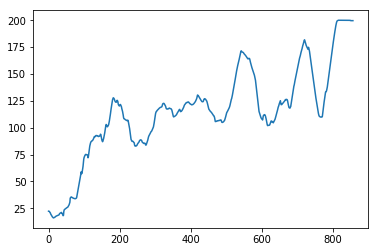

In [38]:
agent = DQNCartPoleSolver(epsilon=0.6)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

[Episode 0] - Mean survival time over last 100 episodes was 20.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 19.96 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 28.03 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 101.06 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 101.69 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 123.04 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 152.88 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 142.13 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 154.24 ticks.
Ran 879 episodes. Solved after 779 trials ✔


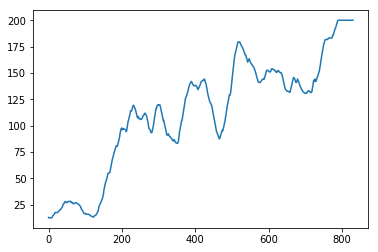

In [42]:
agent = DQNCartPoleSolver(epsilon=0.5)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

[Episode 0] - Mean survival time over last 100 episodes was 11.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 9.76 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 12.12 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 38.04 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 53.28 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 106.39 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 103.19 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 104.72 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 104.55 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 135.44 ticks.
Did not solve after 999 episodes 😞


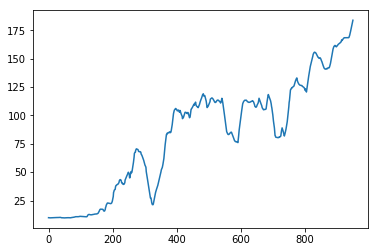

In [39]:
agent = DQNCartPoleSolver(epsilon=0.4)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

[Episode 0] - Mean survival time over last 100 episodes was 10.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 9.72 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 11.05 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 22.64 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 42.32 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 36.0 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 122.09 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 123.06 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 141.22 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 144.12 ticks.
Did not solve after 999 episodes 😞


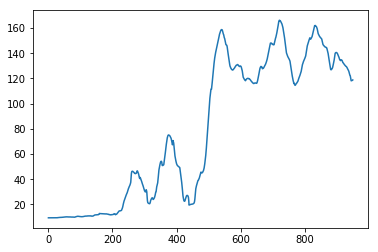

In [40]:
agent = DQNCartPoleSolver(epsilon=0.2)
list_plot=agent.run()
r_cumsum = np.cumsum(np.insert(list_plot[1], 0, 0))
r_smoothed = (r_cumsum[50:] - r_cumsum[:-50]) / 50

plt.plot(r_smoothed)
plt.show()

Epsilon controls for exploration vs explotation which means that higher values of epsilon will introduce more "exploration" to the model and the agent will have more information about more states-policies. On the other hand, smaller values of epsilon will imply the agent plays the best known policy with higher probabilities. I ran the model with epsilon= 1, 0.9, 0.6, 0.5, 0.4 , 0.2. As it was expected, the model tends to be more "unstable" for higher values of epsilon. However, for smaller values the rewards flatten in a point lower than the optimal, which means the agent did not learn how to play the game. It is also possible to see values around 0.5 present the best performance. It should be noticed that the decay rate in epsilon is another way of controling this. 